### Ship sailing strategies with various combinations of payloads and velocities for passing a bottleneck waterway section

### Steps before sailing: 
- Giving a sailing route, in which there is an section with limited water depth (h_min)
- Listing a group of possible actual draughts depending on the limited water depth and minimum operating draughts
- Using the T2v function to find out the corresponding velocities the ship can sail with to safely pass the bottlenek without grounding
- Displaying the possible actual draughts with its maximum sailing velocities and suggesting several sailing strategies.

### Steps while sailing: 
- c

In [1]:
import functools
import itertools
import warnings
warnings.filterwarnings('ignore')

# package(s) related to time, space and id
import logging
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import tqdm

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')



### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).

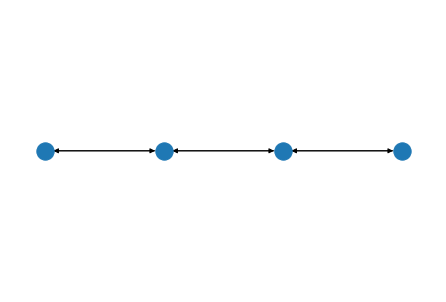

In [2]:
FG = nx.DiGraph()
nodes = []
path = []

Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

data_node_1 = {"name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"name": "Node 2",
               "geometry": shapely.geometry.Point(0.8983, 0)}  # 0.8983 degree =100km
data_node_3 = {"name": "Node 3",
               "geometry": shapely.geometry.Point(1.7966, 0)}   # 1.7966 degree =200km
data_node_4 = {"name": "Node 4",
               "geometry": shapely.geometry.Point(2.6949, 0)}    # 2.6949 degree =300km

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3], # From node 4 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_2, node_1]] # From node 2 to node 1


for edge in path:
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": 6})
    
middle_edges = [
    (node_2.name, node_3.name),
    (node_3.name, node_2.name)
]
for e in middle_edges:
    edge = FG.edges[e]
    edge['Info']['GeneralDepth'] = 2.5

# env.FG = FG
nx.draw(FG, positions)
plt.show()

In [3]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 1', 'Node 2') is 6
General depth for edge ('Node 2', 'Node 3') is 2.5
General depth for edge ('Node 2', 'Node 1') is 6
General depth for edge ('Node 3', 'Node 4') is 6
General depth for edge ('Node 3', 'Node 2') is 2.5
General depth for edge ('Node 4', 'Node 3') is 6


### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption.  

In [4]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.HasContainer,  # needed to calculate filling degree for draught
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [5]:
# Create a dict with all important settings
data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 1,  # m/s
               "type": 'Dortmund-Eems (L <= 74 m)', # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "capacity": 2500,   # maximum designed payload
               "level":2500,     # actual payload
               "H_e": None, 
               "H_f": None, 
               "T": None,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
               "current_year":None
              }               

### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [6]:
path = nx.dijkstra_path(FG, node_1.name, node_4.name)
path_bottleneck = nx.dijkstra_path(FG, node_2.name, node_3.name)

### Define T2v function

In [7]:
def T2v(vessel, h_min, bounds=(0, 10)):
    """Compute vessel velocity given the minimum water depth and possible actual draught 
    
    bounds is the limits where to look for a solution for the velocity [m/s]
    returns velocity [m/s]
    """
    
    def seek_v_given_T(v, vessel, h_min):
        """function to optimize"""

#        print('')
#        print('I am in seek_v_given_T')

        
        # compute the maximum draught a vessel can have to pass the minimum water depth section, 
        # considering the maximum squat while sailing in limited water depth.
        h_min = vessel.h_min
        z = (vessel.C_B * (1.94 * v)**2) * (6 * vessel.B * vessel.T / (150 * vessel.h_min) + 0.4) / 100 # vessel.T is the computed T
        
        # print('h_min: {:.2f} m'.format(vessel.h_min))
        # print('static_ukc: {:.2f} m'.format(vessel.static_ukc))
        # print('z: {:.2f} m'.format(z))
        
        # compute difference between given draught (T_strategy) and computed draught (T_computed)
        T_strategy = vessel._T  # the user provided T
        T_computed = vessel.h_min - z - vessel.static_ukc 
        diff = T_strategy - T_computed
        
        # print('T_strategy: {:.2f} m'.format(T_strategy))
        # print('T_computed: {:.2f} m'.format(T_computed))
        # print('T_strategy - T_computed: {:.2f} m'.format(diff))

#        logger.debug(f'optimizing for v: {v}, T_strategy: {T_strategy}, T: {vessel.T}'T_computed: {:.2f} m'.format(T_computed), T: {vessel.T}')
        
        return diff ** 2        
        
#    print('')
#    print('I am in T2v')    

    # fill in some of the parameters that we already know
    fun = functools.partial(seek_v_given_T, vessel=vessel, h_min = vessel.h_min)       

    # lookup a minimum
    fit = scipy.optimize.minimize_scalar(fun, bounds=bounds, method='bounded')

    # check if we found a minimum
    if not fit.success:
        raise ValueError(fit)    

    v_comupted =  fit.x
#    print('v_comupted: {:.2f} m/s'.format(v_comupted))

    return v_comupted
    


### Define formulate_sailing_strategies (T2v) simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [8]:
def formulate_sailing_strategies(FG, path, T_strategy):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG
            
    # create a fresh instance of vessel
#    print('start the vessel')
    vessel = TransportResource(**data_vessel)
    vessel.name = 'Vessel No.1'                     

    # add environment and path to the vessel
    vessel.env = env                                        #the created environment
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)

    # position vessel at the start of the path
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)

    # new properties added
    vessel._T =  T_strategy # start with the minimum operational draft (and fill up)
    
    # get T2v
    v_computed = T2v(vessel, h_min = vessel.h_min)
    #print('v_computed: {:.2f} m/s'.format(v_computed))
    
    # Start the simulation
    env.process(vessel.move())
    env.run()

    
    return v_computed

### Prepare input matrix for 'formulate_sailing_strategies simulation (T2v)'

In [9]:
# give some possible draught for h_min = 2.5 m
# TODO: give T_strategy for passing limited water depth by collectting values between min-operational draught and (h_min-ukc)

T_strategy = [2.15, 2.10, 2.05, 2.00, 1.95, 1.90, 1.85, 1.80, 1.75, 1.70, 1.65, 1.60, 1.55, 1.50, 1.45, 1.4] 

In [10]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(T_strategy))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0]}
    rows.append(row)

    # these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,T_strategy
11,1.60
12,1.55
13,1.50
14,1.45
15,1.40


### Run 'formulate_sailing_strategies simulation' to get sailing veolicites for the given draughts

In [11]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    T_strategy = row['T_strategy']
    
    v_computed = formulate_sailing_strategies(FG, path, T_strategy)
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_computed'] = v_computed
    
    Strategies.append(Strategy)
    

16it [00:00, 471.80it/s]


In [12]:
Strategies_df = pd.DataFrame(Strategies)
Strategies_df.head(16)

,T_strategy,v_computed
0,2.15,1.404648
1,2.10,1.998008
2,2.05,2.461425
3,2.00,2.859104
4,1.95,3.215806
5,1.90,3.544189
6,1.85,3.851763
7,1.80,4.143408
8,1.75,4.422524
9,1.70,4.691591


### Test the reality of sailing with v_computed
We test it by comparing the total required power (P_tot) of the ship while sailing at v_computed with its installed power (P_installed). If P_tot <= P_installed, the v_computed is realistic.

So the steps to do:
- set the above results [Strategies: 'T_strategy','v_computed'] as input data for a vessel sailing and consuming energy simulation
- run the simulation to get results: 'P_tot', 'P_installed', 'total fuel use', 'total emissions_CO2', 'total emissions_PM10', 'total emissions_NOx', 'duration', 'payload'. (Note that you need the "T2payload" function based on "Van Dorsser's method" to get the corresponding 'payload'for each 'T_strategy'.) 
- put the results into dataframe for later easy selecting, processing and plotting
- select the Strategies of which P_tot <= P_installed 
- analysis the selected Strategies 
- visualize some typical selected Strategies via a series Bar Chart. In each bar chart, y_axis is amount, x_axis is evaluation items.
- visualize some typical selected Strategies together with ambient waterway sections of different water depths.(Note that the input [Vs, P_tot_given] are different for bottle neck section and ambient sections)

### define simulation for passing bottleneck section

In [13]:
def run_simulation(v_computed, T_strategy):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path_bottleneck                #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel._T = T_strategy
    vessel.v = v_computed
    
    print(vessel._T)
 
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

### Run simulation

In [24]:
for i, row in tqdm.tqdm(Strategies_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)   
    
    v_computed = row['v_computed']
    T_strategy = row['T_strategy']
    
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel=  run_simulation(v_computed, T_strategy)
    
    #create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    P_tot = vessel.calculate_total_power_required(v_computed)
    # create dataframe from energy calculation computation
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    df.update(row)
    
    # add/modify some comlums to suit our plotting needs
    # df['P_tot'] = P_tot
    df['fuel_kg_bottleneck'] = df['total_fuel_consumption']/1000   # g --> kg
    df['CO2_g_bottleneck']   = df['total_emission_CO2']
    df['PM10_g_bottleneck']  = df['total_emission_PM10']
    df['NOx_g_bottleneck']   = df['total_emission_NOX']
    df['duration_hrs_bottleneck'] = df['delta_t'] /3600  # s--> hour
    
    df_collect = df.append(df, ignore_index = True)

    display(df_collect)

    


0it [00:00, ?it/s]Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", li

2.15


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 18:22:04.997149,2022-02-24 14:08:35.994298,POINT (0.8983 0),POINT (1.7966 0),107.172961,1750.0,2119.374996,578634.860313,1.835851e+06,1914.121655,36814.173785,0,2.5,99998.29858,71190.997149,578.63486,1.835851e+06,1914.121655,36814.173785,19.775277
1,2022-02-23 18:22:04.997149,2022-02-24 14:08:35.994298,POINT (0.8983 0),POINT (1.7966 0),107.172961,1750.0,2119.374996,578634.860313,1.835851e+06,1914.121655,36814.173785,0,2.5,99998.29858,71190.997149,578.63486,1.835851e+06,1914.121655,36814.173785,19.775277


1it [00:00,  1.62it/s]Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py"

2.1


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 12:29:44.002676,2022-02-24 02:23:53.005352,POINT (0.8983 0),POINT (1.7966 0),139.390037,1750.0,1937.870088,522801.198616,1.658706e+06,1519.016148,30130.197002,0,2.5,99998.29858,50049.002676,522.801199,1.658706e+06,1519.016148,30130.197002,13.902501
1,2022-02-23 12:29:44.002676,2022-02-24 02:23:53.005352,POINT (0.8983 0),POINT (1.7966 0),139.390037,1750.0,1937.870088,522801.198616,1.658706e+06,1519.016148,30130.197002,0,2.5,99998.29858,50049.002676,522.801199,1.658706e+06,1519.016148,30130.197002,13.902501


Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setatt

2.05


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 09:52:41.186464,2022-02-23 21:09:47.372928,POINT (0.8983 0),POINT (1.7966 0),179.493251,1750.0,2025.590634,538525.714512,1.708595e+06,1307.786986,27235.746457,0,2.5,99998.29858,40626.186464,538.525715,1.708595e+06,1307.786986,27235.746457,11.285052
1,2022-02-23 09:52:41.186464,2022-02-23 21:09:47.372928,POINT (0.8983 0),POINT (1.7966 0),179.493251,1750.0,2025.590634,538525.714512,1.708595e+06,1307.786986,27235.746457,0,2.5,99998.29858,40626.186464,538.525715,1.708595e+06,1307.786986,27235.746457,11.285052


Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setatt

2.0


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 08:18:30.393780,2022-02-23 18:01:25.787560,POINT (0.8983 0),POINT (1.7966 0),242.845873,1750.0,2359.341677,615982.782564,1.954345e+06,1311.446455,28790.268197,0,2.5,99998.29858,34975.39378,615.982783,1.954345e+06,1311.446455,28790.268197,9.715387
1,2022-02-23 08:18:30.393780,2022-02-23 18:01:25.787560,POINT (0.8983 0),POINT (1.7966 0),242.845873,1750.0,2359.341677,615982.782564,1.954345e+06,1311.446455,28790.268197,0,2.5,99998.29858,34975.39378,615.982783,1.954345e+06,1311.446455,28790.268197,9.715387


4it [00:00,  6.40it/s]Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py"

1.95


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 07:13:50.873212,2022-02-23 15:52:06.746423,POINT (0.8983 0),POINT (1.7966 0),382.206251,1750.0,3301.399199,829907.333938,2.633070e+06,1537.441798,36187.624193,0,2.5,99998.29858,31095.873211,829.907334,2.633070e+06,1537.441798,36187.624193,8.637743
1,2022-02-23 07:13:50.873212,2022-02-23 15:52:06.746423,POINT (0.8983 0),POINT (1.7966 0),382.206251,1750.0,3301.399199,829907.333938,2.633070e+06,1537.441798,36187.624193,0,2.5,99998.29858,31095.873211,829.907334,2.633070e+06,1537.441798,36187.624193,8.637743


Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setatt

1.9


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 06:25:49.719518,2022-02-23 14:16:04.439037,POINT (0.8983 0),POINT (1.7966 0),738.804227,1750.0,5790.320567,1.351743e+06,4.288711e+06,2365.069087,59392.527275,0,2.5,99998.29858,28214.719519,1351.742819,4.288711e+06,2365.069087,59392.527275,7.837422
1,2022-02-23 06:25:49.719518,2022-02-23 14:16:04.439037,POINT (0.8983 0),POINT (1.7966 0),738.804227,1750.0,5790.320567,1.351743e+06,4.288711e+06,2365.069087,59392.527275,0,2.5,99998.29858,28214.719519,1351.742819,4.288711e+06,2365.069087,59392.527275,7.837422


6it [00:00,  9.09it/s]Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py"

1.85


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 05:48:16.697345,2022-02-23 13:00:58.394690,POINT (0.8983 0),POINT (1.7966 0),1404.762997,1750.0,10130.564378,2.228724e+06,7.071134e+06,3968.975438,99249.139214,0,2.5,99998.29858,25961.697345,2228.724163,7.071134e+06,3968.975438,99249.139214,7.211583
1,2022-02-23 05:48:16.697345,2022-02-23 13:00:58.394690,POINT (0.8983 0),POINT (1.7966 0),1404.762997,1750.0,10130.564378,2.228724e+06,7.071134e+06,3968.975438,99249.139214,0,2.5,99998.29858,25961.697345,2228.724163,7.071134e+06,3968.975438,99249.139214,7.211583


Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setatt

1.8


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 05:17:49.311982,2022-02-23 12:00:03.623963,POINT (0.8983 0),POINT (1.7966 0),2364.049561,1750.0,15848.530457,3.556410e+06,1.128352e+07,6149.229817,155268.052889,0,2.5,99998.29858,24134.311981,3556.410235,1.128352e+07,6149.229817,155268.052889,6.703976
1,2022-02-23 05:17:49.311982,2022-02-23 12:00:03.623963,POINT (0.8983 0),POINT (1.7966 0),2364.049561,1750.0,15848.530457,3.556410e+06,1.128352e+07,6149.229817,155268.052889,0,2.5,99998.29858,24134.311981,3556.410235,1.128352e+07,6149.229817,155268.052889,6.703976


8it [00:00, 11.29it/s]Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py"

1.75


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 04:52:26.136817,2022-02-23 11:09:17.273634,POINT (0.8983 0),POINT (1.7966 0),5234.171448,1750.0,32875.157427,7.377185e+06,2.340580e+07,12755.561082,322077.917312,0,2.5,99998.29858,22611.136817,7377.185327,2.340580e+07,12755.561082,322077.917312,6.280871
1,2022-02-23 04:52:26.136817,2022-02-23 11:09:17.273634,POINT (0.8983 0),POINT (1.7966 0),5234.171448,1750.0,32875.157427,7.377185e+06,2.340580e+07,12755.561082,322077.917312,0,2.5,99998.29858,22611.136817,7377.185327,2.340580e+07,12755.561082,322077.917312,6.280871


Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setatt

1.7


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 04:30:49.366328,2022-02-23 10:26:03.732655,POINT (0.8983 0),POINT (1.7966 0),4169.891533,1750.0,24688.498797,5.540099e+06,1.757722e+07,9579.137533,241873.222717,0,2.5,99998.29858,21314.366327,5540.09913,1.757722e+07,9579.137533,241873.222717,5.920657
1,2022-02-23 04:30:49.366328,2022-02-23 10:26:03.732655,POINT (0.8983 0),POINT (1.7966 0),4169.891533,1750.0,24688.498797,5.540099e+06,1.757722e+07,9579.137533,241873.222717,0,2.5,99998.29858,21314.366327,5540.09913,1.757722e+07,9579.137533,241873.222717,5.920657


10it [00:01, 12.86it/s]Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py

1.65


Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setatt

,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 04:12:06.519412,2022-02-23 09:48:38.038824,POINT (0.8983 0),POINT (1.7966 0),5991.089438,1750.0,33602.555193,7.540413e+06,2.392368e+07,13037.791415,329204.233224,0,2.5,99998.29858,20191.519412,7540.413385,2.392368e+07,13037.791415,329204.233224,5.608755
1,2022-02-23 04:12:06.519412,2022-02-23 09:48:38.038824,POINT (0.8983 0),POINT (1.7966 0),5991.089438,1750.0,33602.555193,7.540413e+06,2.392368e+07,13037.791415,329204.233224,0,2.5,99998.29858,20191.519412,7540.413385,2.392368e+07,13037.791415,329204.233224,5.608755


Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setatt

1.6


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 03:55:40.738288,2022-02-23 09:15:46.476575,POINT (0.8983 0),POINT (1.7966 0),8480.244948,1750.0,45241.4903,1.015219e+07,3.221013e+07,17553.698237,443230.880474,0,2.5,99998.29858,19205.738287,10152.190423,3.221013e+07,17553.698237,443230.880474,5.334927
1,2022-02-23 03:55:40.738288,2022-02-23 09:15:46.476575,POINT (0.8983 0),POINT (1.7966 0),8480.244948,1750.0,45241.4903,1.015219e+07,3.221013e+07,17553.698237,443230.880474,0,2.5,99998.29858,19205.738287,10152.190423,3.221013e+07,17553.698237,443230.880474,5.334927


12it [00:01, 14.24it/s]Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py

1.55


    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 03:41:05.251963,2022-02-23 08:46:35.503926,POINT (0.8983 0),POINT (1.7966 0),9915.972167,1750.0,50489.518969,1.132985e+07,3.594652e+07,19589.93336,494645.817338,0,2.5,99998.29858,18330.251963,11329.848057,3.594652e+07,19589.93336,494645.817338,5.091737
1,2022-02-23 03:41:05.251963,2022-02-23 08:46:35.503926,POINT (0.8983 0),POINT (1.7966 0),9915.972167,1750.0,50489.518969,1.132985e+07,3.594652e+07,19589.93336,494645.817338,0,2.5,99998.29858,18330.251963,11329.848057,3.594652e+07,19589.93336,494645.817338,5.091737


Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setatt

1.5


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 03:28:01.095172,2022-02-23 08:20:26.190345,POINT (0.8983 0),POINT (1.7966 0),10086.244572,1750.0,49156.700267,1.103076e+07,3.499760e+07,19072.799704,481588.192515,0,2.5,99998.29858,17545.095173,11030.76354,3.499760e+07,19072.799704,481588.192515,4.873638
1,2022-02-23 03:28:01.095172,2022-02-23 08:20:26.190345,POINT (0.8983 0),POINT (1.7966 0),10086.244572,1750.0,49156.700267,1.103076e+07,3.499760e+07,19072.799704,481588.192515,0,2.5,99998.29858,17545.095173,11030.76354,3.499760e+07,19072.799704,481588.192515,4.873638


14it [00:01, 15.56it/s]Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py

1.45


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 03:16:11.039085,2022-02-23 07:56:46.078169,POINT (0.8983 0),POINT (1.7966 0),9513.024677,1750.0,44486.706178,9.982817e+06,3.167276e+07,17260.841997,435836.260422,0,2.5,99998.29858,16835.039084,9982.816866,3.167276e+07,17260.841997,435836.260422,4.6764
1,2022-02-23 03:16:11.039085,2022-02-23 07:56:46.078169,POINT (0.8983 0),POINT (1.7966 0),9513.024677,1750.0,44486.706178,9.982817e+06,3.167276e+07,17260.841997,435836.260422,0,2.5,99998.29858,16835.039084,9982.816866,3.167276e+07,17260.841997,435836.260422,4.6764


Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute
Exception ignored in: <function BaseGeometry.__del__ at 0x00000299C6383C10>
Traceback (most recent call last):
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\ANACONDA2021\envs\sim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setatt

1.4


,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_bottleneck,CO2_g_bottleneck,PM10_g_bottleneck,NOx_g_bottleneck,duration_hrs_bottleneck
0,2022-02-23 03:05:24.207516,2022-02-23 07:35:12.415031,POINT (0.8983 0),POINT (1.7966 0),8860.223826,1750.0,39841.983869,8.940541e+06,2.836590e+07,15458.689741,390331.915965,0,2.5,99998.29858,16188.207515,8940.54118,2.836590e+07,15458.689741,390331.915965,4.496724
1,2022-02-23 03:05:24.207516,2022-02-23 07:35:12.415031,POINT (0.8983 0),POINT (1.7966 0),8860.223826,1750.0,39841.983869,8.940541e+06,2.836590e+07,15458.689741,390331.915965,0,2.5,99998.29858,16188.207515,8940.54118,2.836590e+07,15458.689741,390331.915965,4.496724


16it [00:01, 11.31it/s]


In [17]:
# # create empty plot data

# # loop through the various input data
# for index, value in enumerate(T_strategy):
    
#     # Run a basic simulation with V_computed and T_strategy combi
#     vessel = run_simulation(v_computed[index], T_strategy[index])
    
#     #create an EnergyCalculation object and perform energy consumption calculation
#     energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
#     energycalculation.calculate_energy_consumption()
#     P_tot = vessel.calculate_total_power_required(v_computed[index])
#     # create dataframe from energy calculation computation
#     df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
#     # add/modify some comlums to suit our plotting needs
#     df['P_tot'] = P_tot
#     df['fuel_kg_bottleneck'] = df['total_fuel_consumption']/1000   # g --> kg
#     df['CO2_g_bottleneck']   = df['total_emission_CO2']
#     df['PM10_g_bottleneck']  = df['total_emission_PM10']
#     df['NOx_g_bottleneck']   = df['total_emission_NOX']
#     df['duration_hrs_bottleneck'] = df['delta_t'] /3600     # s --> hour           
    


In [18]:
df['fuel_kg_bottleneck']

0    8940.54118
Name: fuel_kg_bottleneck, dtype: float64

In [19]:
output_data = [df['P_tot'], df['duration_hrs_bottleneck'], 
                   df['fuel_kg_bottleneck'], df['CO2_g_bottleneck'], df['PM10_g_bottleneck'],df['NOx_g_bottleneck'] ]

output_data_df = pd.DataFrame(output_data)
output_data_df.head(8)


,0
P_tot,8.860224e+03
duration_hrs_bottleneck,4.496724e+00
fuel_kg_bottleneck,8.940541e+03
CO2_g_bottleneck,2.836590e+07
PM10_g_bottleneck,1.545869e+04
NOx_g_bottleneck,3.903319e+05


In [20]:
use dataframe as input run simulation and plot multi-figure sets with strategies, refer to figure 3 5 7 8 9 notebook

SyntaxError: invalid syntax (1215465794.py, line 1)

In [ ]:
do the same to fig 10, 11,13,14,15

In [ ]:
will also influence 3 5 7 8 9, due to v, h_0 variation